In [1]:
var openDigger = require('../src/open_digger');
var query = openDigger.driver.clickhouse.query;
query(
    `SHOW DATABASES`
).then(res=>{
    console.log(res);
})
// This query can’t be made when using the HTTP protocol, since there is no concept of a session.
// query(
//     `USE github_log`
// ).then(res=>{
//     console.log(res);
// })

[
  { name: '_temporary_and_external_tables' },
  { name: 'default' },
  { name: 'github_log' },
  { name: 'system' }
]


# 查询数据库所有的表

In [2]:
query(
    `SHOW TABLES from github_log`
).then(res=>{
    console.log(res);
});

[
  { name: 'year2015' },
  { name: 'year2016' },
  { name: 'year2017' },
  { name: 'year2018' },
  { name: 'year2019' },
  { name: 'year2020' },
  { name: 'year2021' },
  { name: 'year2022' }
]


In [3]:
// 根据 square/dagger 仓库的信息，可以知道其创建于 2012 年，archived 于 2018 年，因此选择 year2015~year2018 四张表
var repo_id = 5279091;
query(
`SELECT SUM(cnt) FROM
(
SELECT COUNT(*) as cnt FROM github_log.year2015 WHERE repo_id = ${repo_id}
UNION ALL
SELECT COUNT(*) as cnt FROM github_log.year2016 WHERE repo_id = ${repo_id}
UNION ALL
SELECT COUNT(*) as cnt FROM github_log.year2017 WHERE repo_id = ${repo_id}
UNION ALL
SELECT COUNT(*) as cnt FROM github_log.year2018 WHERE repo_id = ${repo_id}
)`
).then(res => {console.log(res)});

[ { 'SUM(cnt)': '6845' } ]


In [4]:
var startYear = 2015, endYear = 2018;
var startMonth = 1, endMonth = 12;
var years = [], months = [];
for (let i = startYear; i <= endYear; i++) {
    years[i - startYear] = i;
}
for (let i = startMonth; i <= endMonth; i++) {
    months[i - startMonth] = i;
}
var yms = []
for(let i = 0; i < years.length; i++) {
    for (let j = 0; j < months.length; j++) {
        yms.push({'y': years[i], 'm': months[j]});
    }
}
// 图标横坐标
yms_axis = yms.map(item => item['y'].toString() + '-' + item['m'].toString())

[
  '2015-1', '2015-2',  '2015-3',  '2015-4',
  '2015-5', '2015-6',  '2015-7',  '2015-8',
  '2015-9', '2015-10', '2015-11', '2015-12',
  '2016-1', '2016-2',  '2016-3',  '2016-4',
  '2016-5', '2016-6',  '2016-7',  '2016-8',
  '2016-9', '2016-10', '2016-11', '2016-12',
  '2017-1', '2017-2',  '2017-3',  '2017-4',
  '2017-5', '2017-6',  '2017-7',  '2017-8',
  '2017-9', '2017-10', '2017-11', '2017-12',
  '2018-1', '2018-2',  '2018-3',  '2018-4',
  '2018-5', '2018-6',  '2018-7',  '2018-8',
  '2018-9', '2018-10', '2018-11', '2018-12'
]

# Task 1：每月新增 Star 和 Frok 的个数

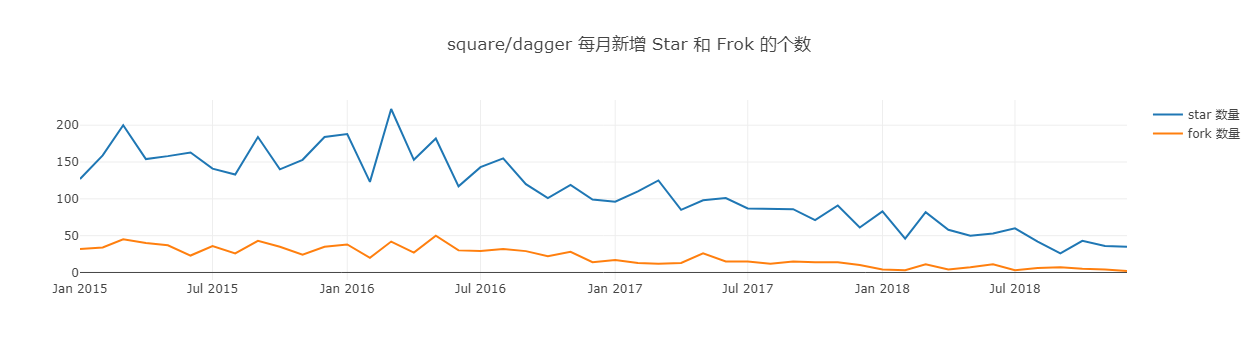

In [5]:
Promise.all(yms.map(ym => {
    var q = `
            SELECT count(CASE WHEN repo_id = ${repo_id} AND type = 'WatchEvent' AND toMonth(created_at) = ${ym['m']} THEN 1 ELSE NULL END) AS star,
            count(CASE WHEN repo_id = ${repo_id} AND type='ForkEvent' AND toMonth(created_at) = ${ym['m']} THEN 1 ELSE NULL END) AS fork
            FROM github_log.year${ym['y']}
            `
    return query(q);
})).then(data => {
    var starCount = [], tableDict = [], forkCount = [];
    data.forEach((d, i) => {
        starCount.push(d[0].star);
        forkCount.push(d[0].fork);
        tableDict.push({'ym': yms_axis[i], 'star': starCount[starCount.length-1], 'fork': forkCount[forkCount.length-1]});
    });
    openDigger.render.plotly([
        {x: yms_axis, y: starCount, mode: 'scatter', name: 'star 数量'},
        {x: yms_axis, y: forkCount, mode: 'scatter', name: 'fork 数量'},
    ], {
        title: 'square/dagger 每月新增 Star 和 Frok 的个数',
    });
    console.table(tableDict.map((d) => {
        return {
            '日期': d.ym,
            'star 数量': d.star,
            'fork 数量': d.fork,
        };
    }));
})

# Task 2: 每月打开 Issue 和 关闭 Issue 的个数

┌─────────┬───────────┬───────────┬───────────┐
│ (index) │   日期    │ star 数量 │ fork 数量 │
├─────────┼───────────┼───────────┼───────────┤
│    0    │ '2015-1'  │   '127'   │   '32'    │
│    1    │ '2015-2'  │   '159'   │   '34'    │
│    2    │ '2015-3'  │   '200'   │   '45'    │
│    3    │ '2015-4'  │   '154'   │   '40'    │
│    4    │ '2015-5'  │   '158'   │   '37'    │
│    5    │ '2015-6'  │   '163'   │   '23'    │
│    6    │ '2015-7'  │   '141'   │   '36'    │
│    7    │ '2015-8'  │   '133'   │   '26'    │
│    8    │ '2015-9'  │   '184'   │   '43'    │
│    9    │ '2015-10' │   '140'   │   '35'    │
│   10    │ '2015-11' │   '153'   │   '24'    │
│   11    │ '2015-12' │   '184'   │   '35'    │
│   12    │ '2016-1'  │   '188'   │   '38'    │
│   13    │ '2016-2'  │   '123'   │   '20'    │
│   14    │ '2016-3'  │   '222'   │   '42'    │
│   15    │ '2016-4'  │   '153'   │   '27'    │
│   16    │ '2016-5'  │   '182'   │   '50'    │
│   17    │ '2016-6'  │   '117'   │   '30'    

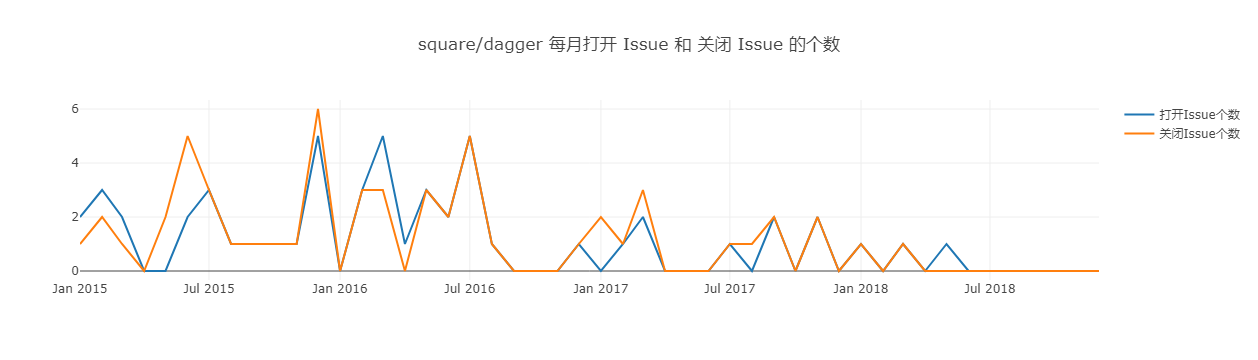

In [7]:
Promise.all(yms.map(ym => {
    var q = `
            SELECT count(CASE WHEN repo_id = ${repo_id} AND type = 'IssuesEvent' AND action = 'opened' AND toMonth(created_at) = ${ym['m']} THEN 1 ELSE NULL END) AS open,
            count(CASE WHEN repo_id = ${repo_id} AND type = 'IssuesEvent' AND action = 'closed' AND toMonth(created_at) = ${ym['m']} THEN 1 ELSE NULL END) AS close
            FROM github_log.year${ym['y']}
            `
    return query(q);
})).then(data => {
    var openCount = [], tableDict = [], closeCount = [];
    data.forEach((d, i) => {
        openCount.push(d[0].open);
        closeCount.push(d[0].close);
        tableDict.push({'ym': yms_axis[i], 'open': openCount[openCount.length-1], 'close': closeCount[closeCount.length-1]});
    });
    openDigger.render.plotly([
        {x: yms_axis, y: openCount, mode: 'scatter', name: '打开Issue个数'},
        {x: yms_axis, y: closeCount, mode: 'scatter', name: '关闭Issue个数'},
    ], {
        title: 'square/dagger 每月打开 Issue 和 关闭 Issue 的个数',
    });
    console.table(tableDict.map((d) => {
        return {
            '日期': d.ym,
            '打开Issue个数': d.open,
            '关闭Issue个数': d.close,
        };
    }));
})

# Task 3：每月打开 PR 和合入 PR 的个数（注意，关闭 PR 不等于合入）

┌─────────┬───────────┬───────────────┬───────────────┐
│ (index) │   日期    │ 打开Issue个数 │ 关闭Issue个数 │
├─────────┼───────────┼───────────────┼───────────────┤
│    0    │ '2015-1'  │      '2'      │      '1'      │
│    1    │ '2015-2'  │      '3'      │      '2'      │
│    2    │ '2015-3'  │      '2'      │      '1'      │
│    3    │ '2015-4'  │      '0'      │      '0'      │
│    4    │ '2015-5'  │      '0'      │      '2'      │
│    5    │ '2015-6'  │      '2'      │      '5'      │
│    6    │ '2015-7'  │      '3'      │      '3'      │
│    7    │ '2015-8'  │      '1'      │      '1'      │
│    8    │ '2015-9'  │      '1'      │      '1'      │
│    9    │ '2015-10' │      '1'      │      '1'      │
│   10    │ '2015-11' │      '1'      │      '1'      │
│   11    │ '2015-12' │      '5'      │      '6'      │
│   12    │ '2016-1'  │      '0'      │      '0'      │
│   13    │ '2016-2'  │      '3'      │      '3'      │
│   14    │ '2016-3'  │      '5'      │      '3'      │
│ 

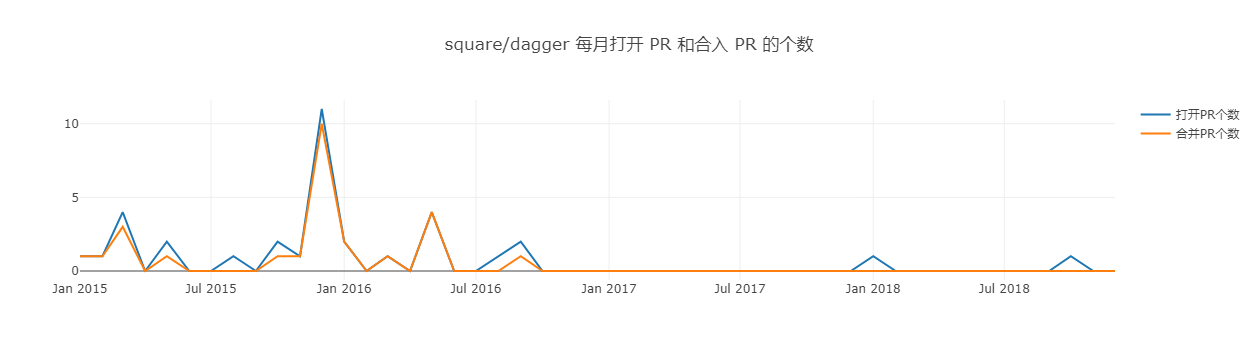

In [8]:
Promise.all(yms.map(ym => {
    var q = `
            SELECT count(CASE WHEN repo_id = ${repo_id} AND type = 'PullRequestEvent' AND action = 'opened' AND toMonth(created_at)=${ym['m']} THEN 1 ELSE NULL END) AS open,
            count(CASE WHEN repo_id = ${repo_id} AND type = 'PullRequestEvent' AND pull_merged = 1 AND toMonth(created_at) = ${ym['m']} THEN 1 ELSE NULL END) AS merge
            FROM github_log.year${ym['y']}
            `
    return query(q);
})).then(data => {
    var openCount = [], tableDict = [], mergeCount = [];
    data.forEach((d, i) => {
        openCount.push(d[0].open);
        mergeCount.push(d[0].merge);
        tableDict.push({'ym': yms_axis[i], 'open': openCount[openCount.length-1], 'merge': mergeCount[mergeCount.length-1]});
    });
    openDigger.render.plotly([
        {x: yms_axis, y: openCount, mode: 'scatter', name: '打开PR个数'},
        {x: yms_axis, y: mergeCount, mode: 'scatter', name: '合并PR个数'},
    ], {
        title: 'square/dagger 每月打开 PR 和合入 PR 的个数',
    });
    console.table(tableDict.map((d) => {
        return {
            '日期': d.ym,
            '打开PR个数': d.open,
            '合并PR个数': d.merge,
        };
    }));
})

# Task 4：每月在仓库中活跃（只要有日志产生就算）的不同开发者（也就是一个GitHub账号）总数


┌─────────┬───────────┬────────────┬────────────┐
│ (index) │   日期    │ 打开PR个数 │ 合并PR个数 │
├─────────┼───────────┼────────────┼────────────┤
│    0    │ '2015-1'  │    '1'     │    '1'     │
│    1    │ '2015-2'  │    '1'     │    '1'     │
│    2    │ '2015-3'  │    '4'     │    '3'     │
│    3    │ '2015-4'  │    '0'     │    '0'     │
│    4    │ '2015-5'  │    '2'     │    '1'     │
│    5    │ '2015-6'  │    '0'     │    '0'     │
│    6    │ '2015-7'  │    '0'     │    '0'     │
│    7    │ '2015-8'  │    '1'     │    '0'     │
│    8    │ '2015-9'  │    '0'     │    '0'     │
│    9    │ '2015-10' │    '2'     │    '1'     │
│   10    │ '2015-11' │    '1'     │    '1'     │
│   11    │ '2015-12' │    '11'    │    '10'    │
│   12    │ '2016-1'  │    '2'     │    '2'     │
│   13    │ '2016-2'  │    '0'     │    '0'     │
│   14    │ '2016-3'  │    '1'     │    '1'     │
│   15    │ '2016-4'  │    '0'     │    '0'     │
│   16    │ '2016-5'  │    '4'     │    '4'     │
│   17    

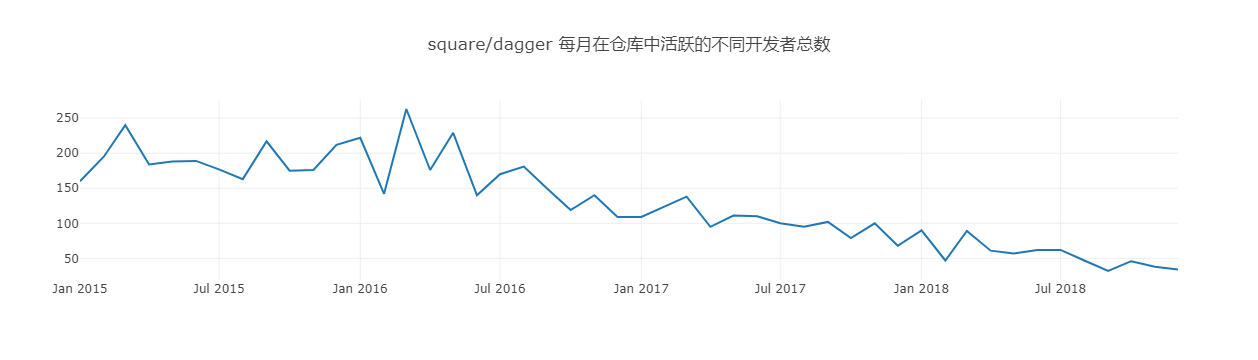

In [8]:
Promise.all(yms.map(ym => {
    var q = `
            SELECT COUNT(DISTINCT actor_id) as user
            FROM github_log.year${ym['y']}
            WHERE repo_id = ${repo_id} AND toMonth(created_at) = ${ym['m']}
            `
    return query(q);
})).then(data => {
    var userCount = [], tableDict = [];
    data.forEach((d, i) => {
        userCount.push(d[0].user);
        tableDict.push({'ym': yms_axis[i], 'user': userCount[userCount.length-1]});
    });
    openDigger.render.plotly([
        {x: yms_axis, y: userCount, mode: 'scatter', name: '开发者总数'},
    ], {
        title: 'square/dagger 每月在仓库中活跃的不同开发者总数',
    });
    console.table(tableDict.map((d) => {
        return {
            '日期': d.ym,
            '开发者总数': d.user,
        };
    }));
})

# Task 5：Issue 从打开到关闭的平均时长和中位数（单位：天）


In [ ]:
// 考虑到大部分的 Issue 都是当天打开，当前关闭，因此首先以小时为单位计算差值，再转化为天数为单位，结果更为精确
query(
    `SELECT avg(duration)/24 as avg_time, quantile(0.5)(duration)/24 as medium_time FROM (
        SELECT toRelativeHourNum(issue_closed_at) - toRelativeHourNum(issue_created_at) AS duration FROM github_log.year2015 WHERE repo_id = ${repo_id} AND type = 'IssuesEvent' AND duration >= 0
        UNION ALL
        SELECT toRelativeHourNum(issue_closed_at) - toRelativeHourNum(issue_created_at) AS duration FROM github_log.year2016 WHERE repo_id = ${repo_id} AND type = 'IssuesEvent' AND duration >= 0
        UNION ALL
        SELECT toRelativeHourNum(issue_closed_at) - toRelativeHourNum(issue_created_at) AS duration FROM github_log.year2017 WHERE repo_id = ${repo_id} AND type = 'IssuesEvent' AND duration >= 0
        UNION ALL
        SELECT toRelativeHourNum(issue_closed_at) - toRelativeHourNum(issue_created_at) AS duration FROM github_log.year2018 WHERE repo_id = ${repo_id} AND type = 'IssuesEvent' AND duration >= 0
    )`
)

# Task 6：PR 从打开到合入的平均时长和中位数（单位：天）


In [10]:
query(
    `SELECT avg(duration) as avg_time, quantile(0.5)(duration) as medium_time FROM(
        SELECT toRelativeHourNum(pull_merged_at) - toRelativeHourNum(issue_created_at) AS duration FROM github_log.year2015 WHERE repo_id = ${repo_id} AND type = 'PullRequestEvent' AND action = 'closed' and pull_merged = 1
        UNION ALL
        SELECT toRelativeHourNum(pull_merged_at) - toRelativeHourNum(issue_created_at) AS duration FROM github_log.year2016 WHERE repo_id = ${repo_id} AND type = 'PullRequestEvent' AND action = 'closed' and pull_merged = 1
        UNION ALL
        SELECT toRelativeHourNum(pull_merged_at) - toRelativeHourNum(issue_created_at) AS duration FROM github_log.year2017 WHERE repo_id = ${repo_id} AND type = 'PullRequestEvent' AND action = 'closed' and pull_merged = 1
        UNION ALL
        SELECT toRelativeHourNum(pull_merged_at) - toRelativeHourNum(issue_created_at) AS duration FROM github_log.year2018 WHERE repo_id = ${repo_id} AND type = 'PullRequestEvent' AND action = 'closed' and pull_merged = 1
    )`
)

[ { avg_time: 15.76923076923077, medium_time: 1.5 } ]

# Task 7： Issue和PR从打开到第一次有人回复（非本人回复）的平均时长和中位数（单位：天）

In [11]:
query(
    `SELECT avg(duration)/24 as avg_time, quantile(0.5)(duration)/24 as medium_time FROM (
        SELECT toRelativeHourNum(min(issue_comment_created_at)) - toRelativeHourNum(min(issue_created_at)) AS duration  FROM (
            SELECT issue_id, issue_created_at, issue_comment_created_at FROM github_log.year2015 WHERE repo_id = ${repo_id} AND issue_id<>0 AND issue_comment_author_id<>0 AND issue_comment_author_id<>issue_author_id
            UNION ALL
            SELECT issue_id, issue_created_at, issue_comment_created_at FROM github_log.year2016 WHERE repo_id = ${repo_id} AND issue_id<>0 AND issue_comment_author_id<>0 AND issue_comment_author_id<>issue_author_id
            UNION ALL
            SELECT issue_id, issue_created_at, issue_comment_created_at FROM github_log.year2017 WHERE repo_id = ${repo_id} AND issue_id<>0 AND issue_comment_author_id<>0 AND issue_comment_author_id<>issue_author_id
         ) GROUP BY issue_id
    )`
)

[ { avg_time: 216.78253424657532, medium_time: 0.25 } ]

# Task 8：根据你观察到的仓库的历史数据，尝试找到几个你认为关键或值得注意的时间节点


- 根据 PR 的打开和合并时间，可以发现 2016 年 9 月之后基本就没有什么 PR 合并的活动了，最后可以在 2018 年 1 月份的一次 PR 中发现，README 中添加了弃用申明： Square's Dagger 1.x is deprecated in favor of Google's Dagger 2. 

- 本项目从 2012 年 6 月份提交了第一个 commit，由于 OpenDigger 只有从 2015 年开始的数据，而对于 `square/dagger` 项目而言，2015 年之后已经算是该项目的后期了，因此例如 Issue，PR 等各项活动都有所减少，故而不能全面的反映 `square/dagger` 项目从诞生到 Archived 的整个过程